# Bayesian Linear Regression for Housing Price Prediction

This notebook implements a Bayesian linear regression model to predict unit prices of houses in Taipei.
We use a conjugate prior to perform exact posterior inference and visualize predictive uncertainty.


1.Data Loading and Preprocessing

In [78]:
import pandas as pd
import numpy as np

df = pd.read_excel("data/real estate.xlsx")
X_raw = df[['X2 house age',
            'X3 distance to the nearest MRT station',
            'X4 number of convenience stores']].values

X = np.hstack([np.ones((X_raw.shape[0], 1)), X_raw])
y = df['Y house price of unit area'].values

n, p = X.shape


2.Prior and Posterior Inference

In [79]:
# Set prior parameters
mu0 = np.zeros(p)
Lambda0 = 0.01 * np.identity(p)
a0 = 1.0
b0 = 1.0

# Compute posterior parameters
Lambda_n = Lambda0 + X.T @ X
mu_n = np.linalg.inv(Lambda_n) @ (Lambda0 @ mu0 + X.T @ y)
a_n = a0 + n / 2
b_n = b0 + 0.5 * (
    y.T @ y + mu0.T @ Lambda0 @ mu0 - mu_n.T @ Lambda_n @ mu_n
)

# Output
print("Posterior mu_n:", mu_n)
print("Posterior a_n:", a_n)
print("Posterior b_n:", b_n)


Posterior mu_n: [ 4.29676922e+01 -2.52732594e-01 -5.37703937e-03  1.29844578e+00]
Posterior a_n: 208.0
Posterior b_n: 17555.708146488992


3.Posterior Sampling and Prediction

In [80]:
from scipy.stats import invgamma, multivariate_normal
import matplotlib.pyplot as plt

n_samples = 500

sigma2_samples = invgamma.rvs(a=a_n, scale=b_n, size=n_samples)

beta_samples = np.array([
    multivariate_normal.rvs(mean=mu_n, cov=np.linalg.inv(Lambda_n) * s2)
    for s2 in sigma2_samples
])

y_pred_samples = X @ beta_samples.T

y_pred_mean = y_pred_samples.mean(axis=1)
y_pred_lower = np.percentile(y_pred_samples, 2.5, axis=1)
y_pred_upper = np.percentile(y_pred_samples, 97.5, axis=1)


4. Visualization

4.1 Figure 1: Predicted vs Actual

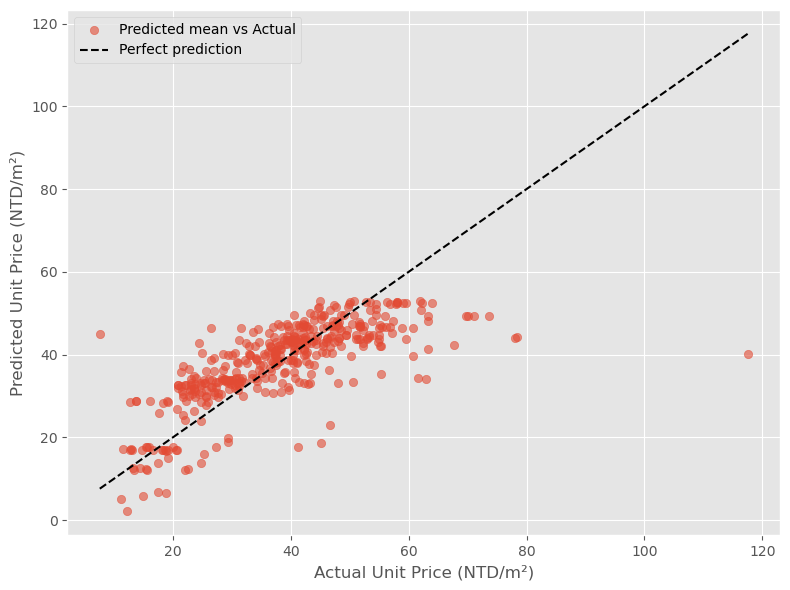

In [81]:

plt.figure(figsize=(8, 6))
plt.scatter(y, y_pred_mean, alpha=0.6, label='Predicted mean vs Actual')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', label='Perfect prediction')
plt.xlabel('Actual Unit Price (NTD/m²)')
plt.ylabel('Predicted Unit Price (NTD/m²)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


4.2 Figure 2: 95% credible intervals

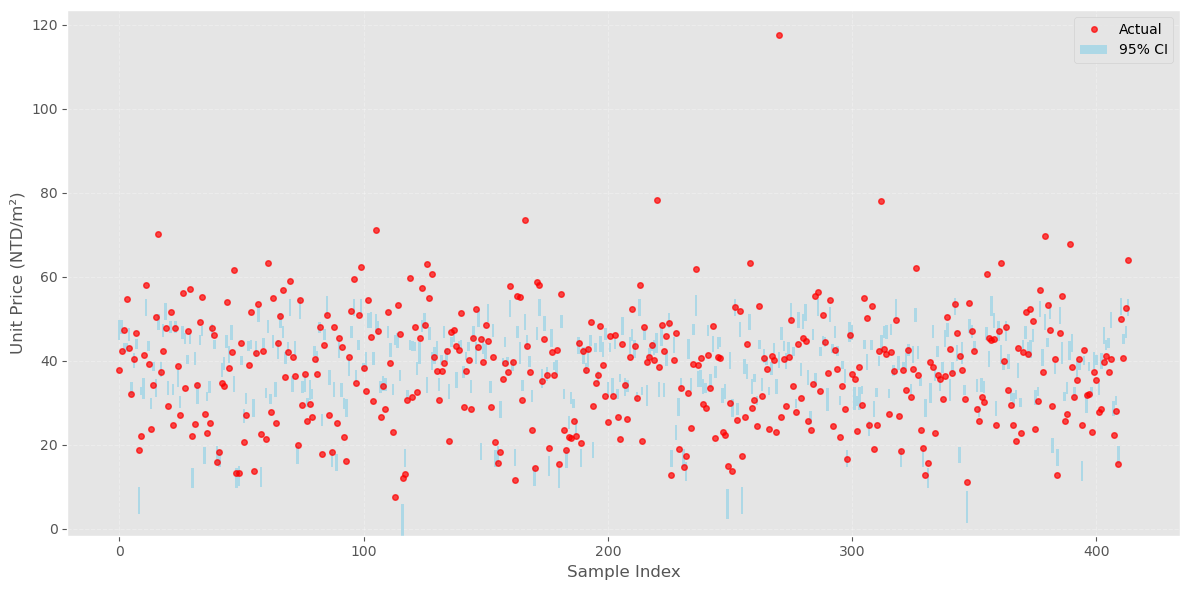

In [82]:
x = np.arange(len(y))
ci_height = y_pred_upper - y_pred_lower
ci_bottom = y_pred_lower

plt.figure(figsize=(12, 6))
plt.bar(x, ci_height, bottom=ci_bottom, color='lightblue', width=1.0, label='95% CI')
plt.plot(x, y, 'o', color='red', alpha=0.7, markersize=4, label='Actual')
plt.xlabel('Sample Index')
plt.ylabel('Unit Price (NTD/m²)')
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


4.3 Figure 3: Posterior Predictive Check for Model1

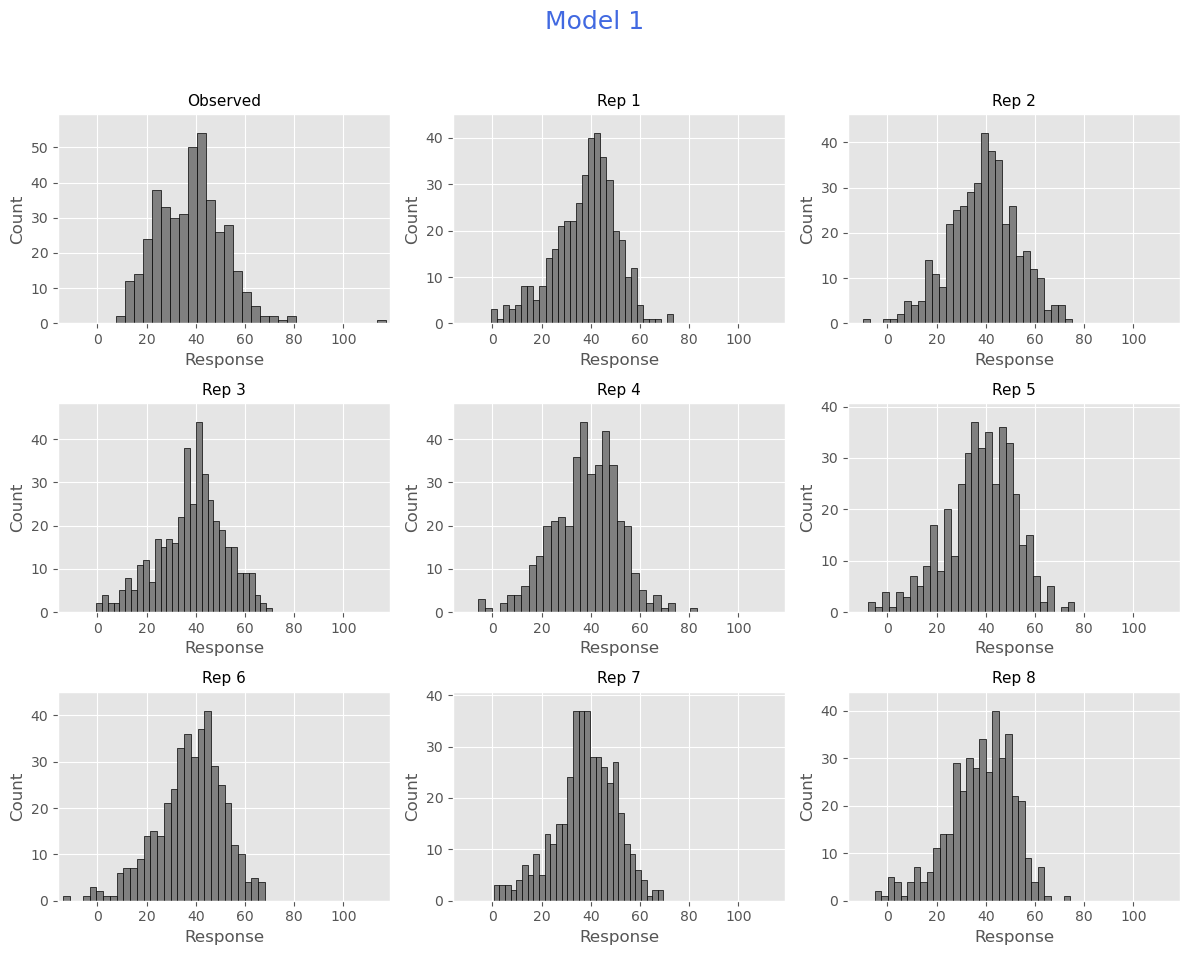

In [83]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import invgamma, multivariate_normal

plt.style.use('ggplot')

def plot_ppc(X, y, mu_n, Lambda_n, a_n, b_n, model_name='Model 1', n_replications=8):
    """
    Generate and plot posterior predictive histograms.
    """
    n_samples = X.shape[0]
    replicated_ys = [y]

    for _ in range(n_replications):
        sigma2_sample = invgamma.rvs(a=a_n, scale=b_n)
        beta_sample = multivariate_normal.rvs(mean=mu_n, cov=sigma2_sample * np.linalg.inv(Lambda_n))
        y_rep = X @ beta_sample + np.random.normal(0, np.sqrt(sigma2_sample), size=n_samples)
        replicated_ys.append(y_rep)

    y_all = np.concatenate(replicated_ys)
    x_min, x_max = np.floor(y_all.min()) - 1, np.ceil(y_all.max()) + 1

    fig, axes = plt.subplots(3, 3, figsize=(12, 10))
    axes = axes.flatten()

    for i in range(9):
        axes[i].hist(replicated_ys[i], bins=30, color='gray', edgecolor='black')
        axes[i].set_xlim(x_min, x_max)

        counts, _ = np.histogram(replicated_ys[i], bins=30)
        axes[i].set_ylim(0, counts.max() * 1.1)

        axes[i].set_xlabel("Response")
        axes[i].set_ylabel("Count")
        axes[i].set_title('Observed' if i == 0 else f'Rep {i}', fontsize=11)

    fig.suptitle(model_name, fontsize=18, color='royalblue')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Call the function for Model 1
plot_ppc(X, y, mu_n, Lambda_n, a_n, b_n, model_name='Model 1')


4.4 Figure 4: PPC for Model 2

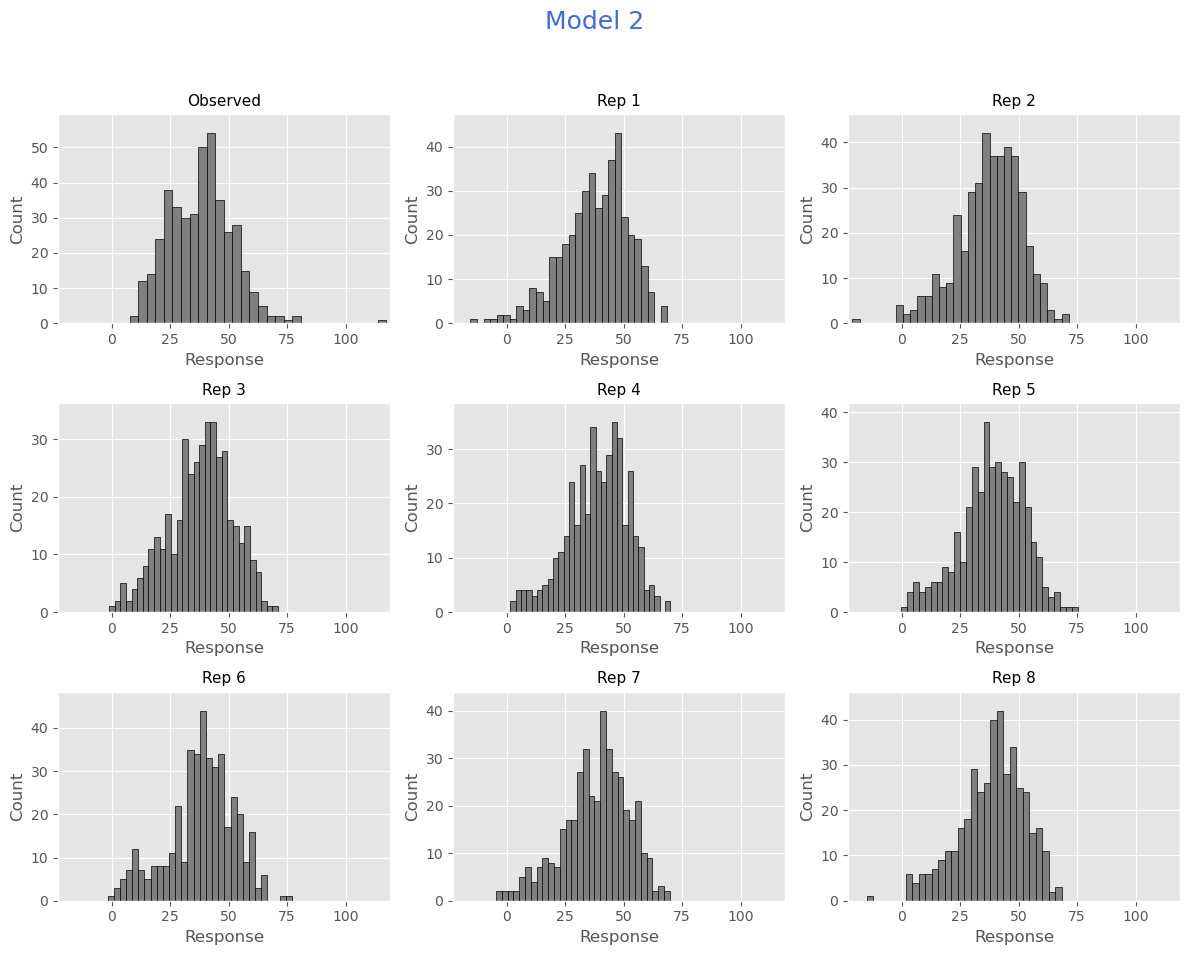

In [84]:
# Construct design matrix with 6 features + intercept
X_raw2 = df[['X1 transaction date',
             'X2 house age',
             'X3 distance to the nearest MRT station',
             'X4 number of convenience stores',
             'X5 latitude',
             'X6 longitude']].values

X2 = np.hstack([np.ones((X_raw2.shape[0], 1)), X_raw2])
y = df['Y house price of unit area'].values

# Get shape
n2, p2 = X2.shape

# Prior setup
mu0_2 = np.zeros(p2)
Lambda0_2 = 0.01 * np.identity(p2)
a0_2 = 1.0
b0_2 = 1.0

# Posterior parameters for Model 2
Lambda_n2 = Lambda0_2 + X2.T @ X2
mu_n2 = np.linalg.inv(Lambda_n2) @ (Lambda0_2 @ mu0_2 + X2.T @ y)
a_n2 = a0_2 + n2 / 2
b_n2 = b0_2 + 0.5 * (y.T @ y + mu0_2.T @ Lambda0_2 @ mu0_2 - mu_n2.T @ Lambda_n2 @ mu_n2)

# Plot PPC for Model 2 
plot_ppc(X2, y, mu_n2, Lambda_n2, a_n2, b_n2, model_name='Model 2')
